## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import os
from glob import glob
import random
import time
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF

from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data

In [ ]:
#!pip install gdown
import gdown

url = 'https://drive.google.com/drive/folders/1Vt0ruP3PrTmDxphqtVRCkLBw5eIe2kbP?usp=sharing'
gdown.download_folder(url, quiet=False)


Retrieving folder contents


Processing file 1qbsiQSZe-e4uKEo4FDbNJgvXqCW8OFm6 TEST.zip
Processing file 1n_RBnZWkd8_HSDySY7NWRbYwMQTk5cKJ train_val.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1qbsiQSZe-e4uKEo4FDbNJgvXqCW8OFm6
To: /content/dataset/TEST.zip
100%|██████████| 12.8M/12.8M [00:00<00:00, 28.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1n_RBnZWkd8_HSDySY7NWRbYwMQTk5cKJ
From (redirected): https://drive.google.com/uc?id=1n_RBnZWkd8_HSDySY7NWRbYwMQTk5cKJ&confirm=t&uuid=b1397dbc-53bb-4089-8870-c8700592d062
To: /content/dataset/train_val.zip
100%|██████████| 172M/172M [00:03<00:00, 44.3MB/s]
Download completed


['/content/dataset/TEST.zip', '/content/dataset/train_val.zip']

In [ ]:
!unzip -q /content/dataset/train_val.zip -d /content/dataset/train_val
!unzip -q /content/dataset/TEST.zip -d /content/dataset

In [ ]:
data_path = '/content/dataset'

train_img_path = os.path.join(data_path, 'train_val/train_val/images')
train_mask_path = os.path.join(data_path, 'train_val/train_val/masks')

test_img_path = os.path.join(data_path, 'TEST/images')
test_mask_path = os.path.join(data_path, 'TEST/masks')

image_paths = sorted(glob(os.path.join(train_img_path, '*')))
mask_paths = sorted(glob(os.path.join(train_mask_path, '*')))

### Plotting random images from dataset with their respective masks andalso add the mask on the original image

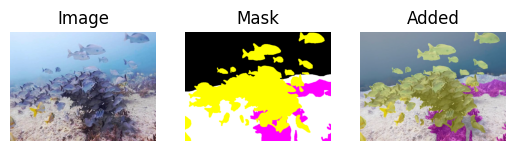

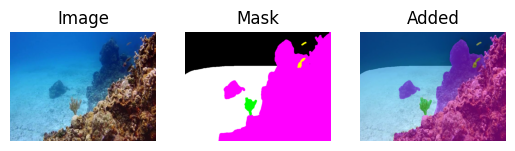

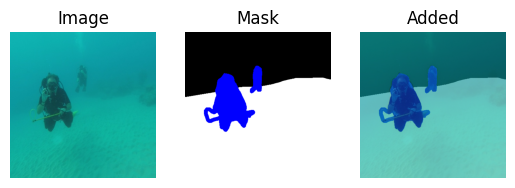

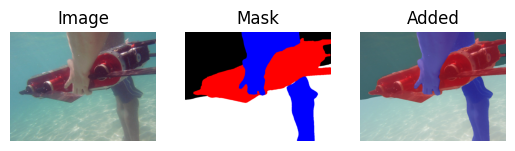

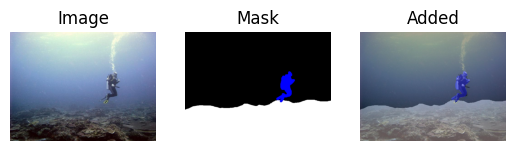

In [ ]:
for i in np.random.randint(0,300,size=5):
    img = imageio.v2.imread(image_paths[i])
    mask = imageio.v2.imread(mask_paths[i])
    added_image = (img*0.65+ mask*0.35).astype(int)
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(added_image)
    plt.title('Added')
    plt.axis('off')
    plt.show()

### Some Utility Functions

In [ ]:
num_classes = 8
h_crop = 160
w_crop = 160
# temp list for one hot conversion and viceversa
binary_encoded = [[0, 0, 0],[0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
one_hot_encoded = [[1 if j == i else 0 for j in range(8)] for i in range(8)]
def bin2ohe(mask, num_class, binary_encoded, one_hot_encoded):
    mask = mask.permute(1,2,0)
    mask = mask.numpy()
    mask = mask.astype(np.int64)
    h,w = mask.shape[:-1]
    layout = np.zeros((h, w, num_class), dtype=np.int64)
    for i, label in enumerate(binary_encoded):
        layout[np.all(mask == label, axis = -1)] = one_hot_encoded[i]
    layout = layout.astype(np.float64)
    layout = torch.from_numpy(layout)
    layout = layout.permute(2,0,1)
    return layout

def ohe2bin(mask, one_hot_encoded, binary_encoded):
    mask = mask.permute(1,2,0)
    mask = mask.numpy()
    h,w = mask.shape[:-1]
    layout = np.zeros((h,w,3), dtype=np.int64)
    for i, label in enumerate(one_hot_encoded):
        layout[np.all(mask == label, axis = -1)] = binary_encoded[i]

    layout = layout.astype(np.float64)
    layout = torch.from_numpy(layout)
    layout = layout.permute(2,0,1)
    return layout

def argmax_predict(pred):
    pred = F.softmax(pred, dim=1)
    pred = pred.numpy()
    # thresholding
    for img in range(pred.shape[0]):
        tmp_pred = pred[img]
        pred_arg = np.argmax(tmp_pred, axis=0)
        layout = np.zeros((h_crop, w_crop, num_classes))

        for i in range(0,num_classes):
            layout[pred_arg == i] = one_hot_encoded[i]
        layout = np.transpose(layout, (2,0,1))
        pred[img] = layout
    return pred

In [ ]:
def plot_img_label(img, label):
    # plot
    img = img.permute(1, 2, 0)

    # ohe to rgb
    test_mask_rgb = ohe2bin(label, one_hot_encoded, binary_encoded)
    test_mask_rgb = test_mask_rgb.permute(1, 2, 0)

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(test_mask_rgb * 1.0)
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10,6))
    for i in range(num_classes):
        plt.subplot(2,4,i + 1)
        plt.axis('off')
        plt.title(f'class {i:03b}')
        plt.imshow(label[i,:,:], cmap='gray')
    plt.show()

def plot_img_label_pred(img, label, pred):
    # pred
    pred = pred.permute(1,2,0)
    pred = pred.numpy()

    pred_arg = np.argmax(pred, axis=2)
    layout = np.zeros((h_crop, w_crop, 3))

    for i in range(0,num_classes):
        layout[pred_arg == i] = binary_encoded[i]

    # plot
    img = img.permute(1, 2, 0)

    # ohe to rgb
    test_mask_rgb = ohe2bin(label, one_hot_encoded, binary_encoded)
    test_mask_rgb = test_mask_rgb.permute(1, 2, 0)

    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(test_mask_rgb * 1.0)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(layout * 1.0)
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10,6))
    for i in range(num_classes):
        plt.subplot(2,4,i + 1)
        plt.axis('off')
        plt.title(f'class {i:03b}')
        plt.imshow(label[i,:,:], cmap='gray')
    plt.show()

    plt.figure(figsize=(10,6))
    for i in range(num_classes):
        plt.subplot(2,4,i + 1)
        plt.axis('off')
        plt.title(f'class {i:03b}')
        plt.imshow(pred[:,:,i], cmap='gray')
    plt.show()

### Define Dataloader

In [ ]:
# Dataset Hyperparameter
h_crop = 160
w_crop = 160
rot_angle = 30 # Rotation angle generated randomly between [-rot_angle, rot_angle]
rot_flag = True
shuffle_flag = True
shear_angle = 30
shear_flag = True
pixel_translate = 50
translate_flag = True
vflip_flag = True
hflip_flag = True
class SuimDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, transform_flag=True, hflip=False, vflip=False, rotate=False, shear=False, translate=False):
        self.image_paths = imgs_dir
        self.mask_paths = masks_dir
        self.transform_flag = transform_flag
        self.hflip = hflip
        self.vflip = vflip
        self.rotate = rotate
        self.shear = shear
        self.translate = translate

    def transform(self, image, mask):
        # random angle interval
        rot_interval = [-rot_angle, rot_angle]
        shear_interval = [-shear_angle, shear_angle]
        translate_interval = [-pixel_translate, pixel_translate]

        ran_angle = 0
        ran_translate_x, ran_translate_y = 0, 0
        ran_shear_angle = 0


        image = TF.resize(image, [h_crop,w_crop], interpolation=T.InterpolationMode.NEAREST)
        mask = TF.resize(mask, [h_crop,w_crop], interpolation=T.InterpolationMode.NEAREST)

        # Generate 8 mask for each class from the bitmap mask
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = torch.round(mask)

        if self.transform_flag:
            image = TF.pad(image, padding=h_crop//2, padding_mode="reflect")
            mask = TF.pad(mask, padding=h_crop//2, padding_mode="reflect")
            # horizontal flipping
            if self.hflip:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            # vertical flipping
            if self.vflip:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            if self.rotate:
                ran_angle = random.uniform(rot_interval[0], rot_interval[1])
            if self.shear:
                ran_shear_angle = random.uniform(shear_interval[0], shear_interval[1])
            if self.translate:
                ran_translate_x = random.uniform(translate_interval[0], translate_interval[1])
                ran_translate_y = random.uniform(translate_interval[0], translate_interval[1])

            # Apply affine transform with rotation, shear and translation
            image = TF.affine(image, angle=ran_angle, translate=(ran_translate_x,ran_translate_y), scale=1, shear=ran_shear_angle, interpolation=T.InterpolationMode.NEAREST)
            mask = TF.affine(mask, angle=ran_angle, translate=(ran_translate_x,ran_translate_y), scale=1, shear=ran_shear_angle, interpolation=T.InterpolationMode.NEAREST)

            cropper = T.CenterCrop(size=[h_crop,w_crop])

            image = cropper(image)
            mask = cropper(mask)

        # One hot encoding
        layout = bin2ohe(mask, num_classes, binary_encoded, one_hot_encoded)
        return image, layout

    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])
        mask = Image.open(self.mask_paths[index])

        image, mask = self.transform(image, mask)
        return image, mask

    def __len__(self):
        return len(self.image_paths)

### Split data to train and validation sets

In [ ]:
# Split in train e val
train_split_img, val_split_img, train_split_mask, val_split_mask = train_test_split(image_paths, mask_paths, test_size=0.1)

dataset1 = SuimDataset(train_split_img, train_split_mask, transform_flag = False)
dataset2 = SuimDataset(train_split_img, train_split_mask, transform_flag = True, hflip=hflip_flag, rotate=rot_flag, shear=shear_flag, translate=translate_flag)
dataset3 = SuimDataset(train_split_img, train_split_mask, transform_flag = True, vflip=vflip_flag, rotate=rot_flag, shear=shear_flag, translate=translate_flag)
dataset4 = SuimDataset(train_split_img, train_split_mask, transform_flag = True, hflip=hflip_flag, vflip=vflip_flag, rotate=rot_flag, shear=shear_flag, translate=translate_flag)

dataset = torch.utils.data.ConcatDataset([dataset1, dataset2, dataset3, dataset4])
dataset_val = SuimDataset(val_split_img, val_split_mask, transform_flag = False)

batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_flag)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=shuffle_flag)

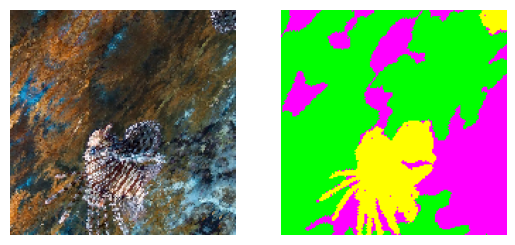

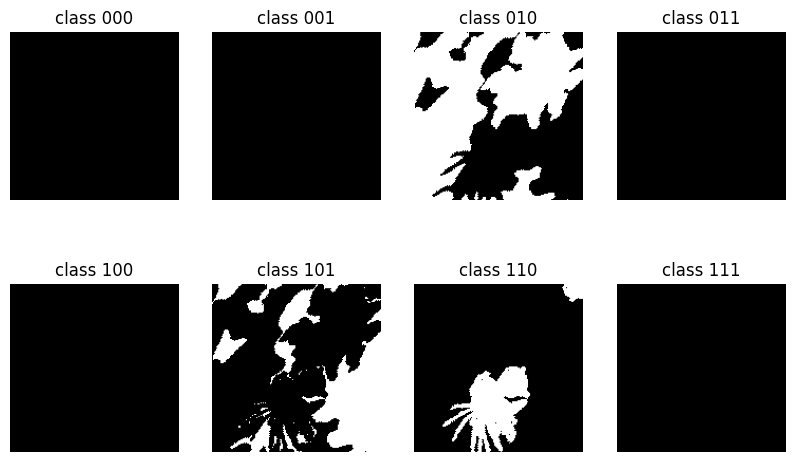

In [ ]:
idx = np.random.randint(0, len(image_paths))

image = Image.open(image_paths[idx])
mask = Image.open(mask_paths[idx])
img,mask = dataset4.transform(image,mask)
plot_img_label(img, mask)

## Define the UNet italicized text

In [ ]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):

    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32))
        self.down2 = (Down(32, 64))
        self.down3 = (Down(64, 128))
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 256 // factor))

        self.up1 = (Up(256, 128 // factor, bilinear))
        self.up2 = (Up(128, 64 // factor, bilinear))
        self.up3 = (Up(64, 32 // factor, bilinear))
        self.up4 = (Up(32, 16, bilinear))
        self.outc = (OutConv(16, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x


model = UNet(3, num_classes)
summary(model.cuda(), (3, h_crop, w_crop))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 160, 160]             432
       BatchNorm2d-2         [-1, 16, 160, 160]              32
              ReLU-3         [-1, 16, 160, 160]               0
            Conv2d-4         [-1, 16, 160, 160]           2,304
       BatchNorm2d-5         [-1, 16, 160, 160]              32
              ReLU-6         [-1, 16, 160, 160]               0
        DoubleConv-7         [-1, 16, 160, 160]               0
         MaxPool2d-8           [-1, 16, 80, 80]               0
            Conv2d-9           [-1, 32, 80, 80]           4,608
      BatchNorm2d-10           [-1, 32, 80, 80]              64
             ReLU-11           [-1, 32, 80, 80]               0
           Conv2d-12           [-1, 32, 80, 80]           9,216
      BatchNorm2d-13           [-1, 32, 80, 80]              64
             ReLU-14           [-1, 32,

## Define some metrics like IoU

In [ ]:
def IoU(preds, masks):
    preds = torch.round(F.softmax(preds.cpu().detach(), dim=1))
    preds = (preds.view(-1)).numpy()
    masks = (masks.cpu().view(-1)).numpy()
    intersection = np.logical_and(preds, masks)
    union = np.logical_or(preds, masks)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def mIoU(preds, masks):
    batch_size = preds.shape[0]
    iou_scores = []

    for i in range(batch_size):
        pred = preds[i]
        mask = masks[i]

        pred = torch.round(F.softmax(pred.cpu().detach(), dim=0))
        pred = (pred.view(-1)).numpy()
        mask = (mask.cpu().view(-1)).numpy()

        intersection = np.logical_and(pred, mask)
        union = np.logical_or(pred, mask)
        iou = np.sum(intersection) / np.sum(union)
        iou_scores.append(iou)

    mean_iou = np.mean(iou_scores)
    return mean_iou

## Train Function

In [ ]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs):
    torch.cuda.empty_cache()
    best_model_wts = copy.deepcopy(model.state_dict())
    since = time.time()
    train_losses = []
    val_losses = []
    train_iou = []
    val_iou = []
    best_val_loss = np.inf
    best_val_iou = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 15)
        tic = time.time()
        # Sum of the loss for each batch
        running_loss = 0
        # Iou score at epoch
        iou_score = 0

        # Training
        model.train()
        for idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            # Model prediction
            output = model(images)
            # Loss and gradient calculation
            loss = loss_fn(output, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            iou_score += IoU(output, masks)
        print(f'Training: Loss = {running_loss/len(train_loader):.3f} mIoU =  {iou_score/len(train_loader):.3f}')
        # Scheduler
        scheduler.step()

        val_running_loss = 0
        val_iou_score = 0
        # Validation
        for idx, (images, masks) in enumerate(val_loader):
            # Set model to evaluation and load data to GPU
            images = images.to(device)
            masks = masks.to(device)
            model.eval()

            output = model(images)
            #Loss and IoU evaluation
            loss = loss_fn(output, masks)

            val_running_loss += loss.item()
            val_iou_score +=  IoU(output, masks)
        print(f'Validation: Loss = {val_running_loss/len(val_loader):.3f} mIoU =  {val_iou_score/len(val_loader):.3f}')

        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_running_loss/len(val_loader))
        val_iou.append(val_iou_score/len(val_loader))
        train_iou.append(iou_score/len(train_loader))

        toc = time.time()
        print(f'Time: {(toc-tic) // 60:.0f}m {(toc-tic) % 60:.0f}s')
        # Saving model with minimum loss on validation set
        if val_iou_score/len(val_loader) > best_val_iou:
            best_val_iou = copy.deepcopy(val_iou_score/len(val_loader))
            best_model_wts = copy.deepcopy(model.state_dict())

    # Epoch end, return history of the loss
    history = {
        'train_losses' : train_losses,
        'val_losses': val_losses,
        'train_iou': train_iou,
        'val_iou':val_iou,
    }
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    torch.save(best_model_wts, 'model_weights_UNet.pth')
    model.load_state_dict(best_model_wts)
    return model, history

## Main

### Loss Weight

Because of class imbalance we calculate how many times each class happened in train dataset and set the loss weight of each one proportional to inverse of it

In [ ]:
class_hap = np.zeros(8)
for i in range(len(dataset1)):
    for cls in range(num_classes):
        class_hap[cls] += np.sum(dataset1[i][1][cls].numpy())
loss_weigths = sum(class_hap)/(6*class_hap)

In [ ]:
loss_weigths

array([ 0.54075807,  8.72741007,  7.56878737,  2.23603104, 45.42494057,
        0.47150679,  2.10883655,  1.19083001])

In [ ]:
loss_weigths = np.array([0.6, 3, 3, 1.5, 3.5, 0.6, 1.5, 1])

### Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(3, num_classes).to(device)
# Defining the Loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(loss_weigths).to(device))
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=2e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
num_epochs = 40
model, history = train_model(model, loss_fn = criterion, optimizer = optimizer,
                       scheduler = exp_lr_scheduler, num_epochs = num_epochs)

Epoch 0/39
---------------
Training: Loss = 1.467 mIoU =  0.208
Validation: Loss = 1.364 mIoU =  0.342
Time: 1m 58s
Epoch 1/39
---------------
Training: Loss = 1.304 mIoU =  0.293
Validation: Loss = 1.274 mIoU =  0.346
Time: 1m 57s
Epoch 2/39
---------------
Training: Loss = 1.230 mIoU =  0.335
Validation: Loss = 1.159 mIoU =  0.419
Time: 1m 57s
Epoch 3/39
---------------
Training: Loss = 1.186 mIoU =  0.358
Validation: Loss = 1.119 mIoU =  0.394
Time: 1m 56s
Epoch 4/39
---------------
Training: Loss = 1.142 mIoU =  0.380
Validation: Loss = 1.111 mIoU =  0.442
Time: 1m 57s
Epoch 5/39
---------------
Training: Loss = 1.115 mIoU =  0.396
Validation: Loss = 1.110 mIoU =  0.398
Time: 1m 56s
Epoch 6/39
---------------
Training: Loss = 1.080 mIoU =  0.412
Validation: Loss = 1.079 mIoU =  0.469
Time: 1m 56s
Epoch 7/39
---------------
Training: Loss = 1.067 mIoU =  0.424
Validation: Loss = 1.136 mIoU =  0.432
Time: 1m 56s
Epoch 8/39
---------------
Training: Loss = 1.031 mIoU =  0.441
Validati

### Plot Loss and mIoU

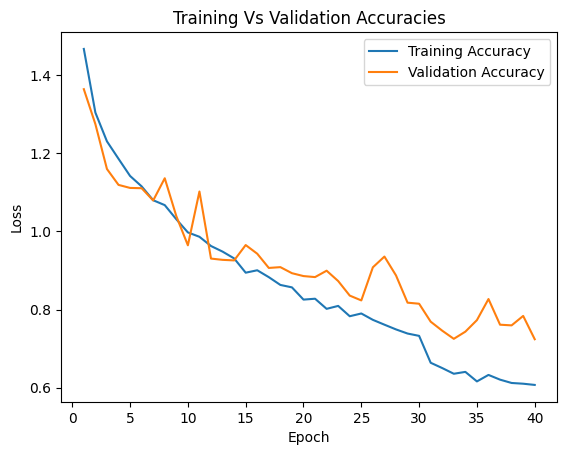

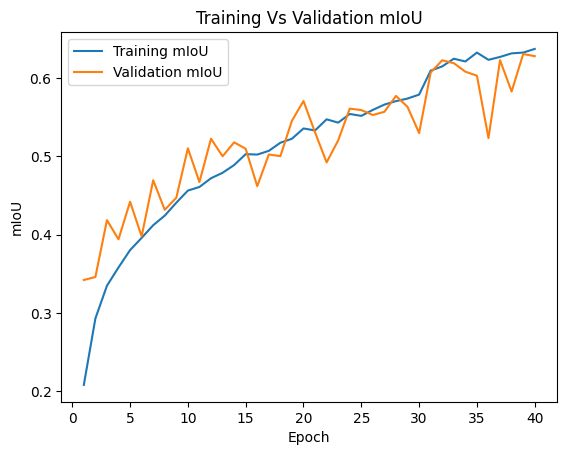

In [ ]:
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(range(1, len(history['train_losses'])+1)), history['train_losses'], label="Training Accuracy")
plt.plot(list(range(1, len(history['val_losses'])+1)), history['val_losses'], label="Validation Accuracy")
plt.legend()
plt.show()

plt.title("Training Vs Validation mIoU")
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.plot(list(range(1, len(history['train_iou'])+1)), history['train_iou'], label="Training mIoU")
plt.plot(list(range(1, len(history['val_iou'])+1)), history['val_iou'], label="Validation mIoU")
plt.legend()
plt.show()

## Test

In [21]:
class SuimTestDataset(Dataset):
    '''
        Dataloader
    '''
    def __init__(self, imgs_dir, masks_dir):
        self.image_paths = sorted(glob(os.path.join(imgs_dir, '*')))
        self.mask_paths = sorted(glob(os.path.join(masks_dir, '*.bmp')))

    def transform(self, image, mask):
        image = TF.resize(image, [h_crop,w_crop], interpolation=T.InterpolationMode.NEAREST)
        mask = TF.resize(mask, [h_crop,w_crop], interpolation=T.InterpolationMode.NEAREST)

        # Generate 8 mask for each class from the bitmap mask
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        # One hot encoding
        layout = bin2ohe(mask, num_classes, binary_encoded, one_hot_encoded)
        return image, layout

    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])
        mask = Image.open(self.mask_paths[index])

        image, mask = self.transform(image, mask)
        return image, mask

    def __len__(self):
        return len(self.image_paths)

In [ ]:
test_dataset = SuimTestDataset(test_img_path, test_mask_path)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
iou_scores = []
for idx,(images, masks) in enumerate(test_loader):
    images = images.to(device)
    masks = masks.to(device)

    model.eval()

    with torch.no_grad():
        pred = model(images)
    iou_score = IoU(pred, masks)
    pred = argmax_predict(pred.cpu())

    iou_scores.append(iou_score)

print(f"Test IoU = {np.mean(iou_scores)}")

Test IoU = 0.6300557652705675


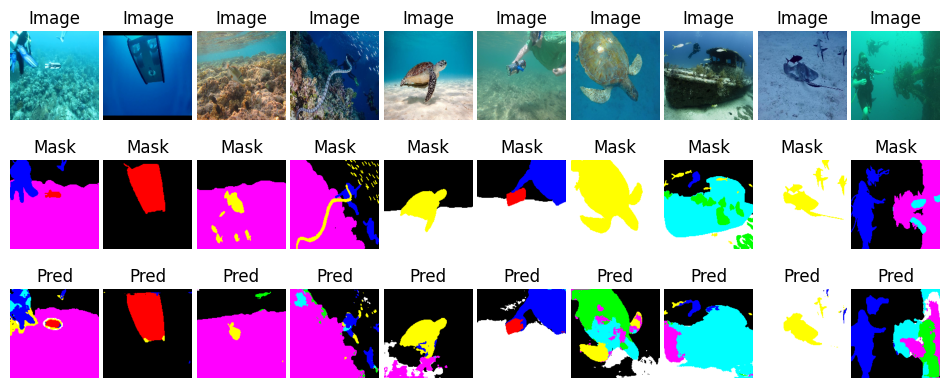

In [ ]:
model.eval()
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
images, masks = next(iter(test_loader))
with torch.no_grad():
    preds = model(images.to(device))
preds = argmax_predict(preds.cpu())
preds = torch.from_numpy(preds)

plt.figure(figsize=(12,5))
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title('Image')
    plt.axis('off')
    mask = ohe2bin(masks[i], one_hot_encoded, binary_encoded)
    mask = mask.permute(1, 2, 0)
    plt.subplot(3,10,i+11)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    pred = ohe2bin(preds[i], one_hot_encoded, binary_encoded)
    plt.subplot(3,10,i+21)
    plt.imshow(pred.permute(1, 2, 0))
    plt.title('Pred')
    plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.01)
plt.show()

## Define the TA-UNet italicized text

In [ ]:
class TAModule(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(TAModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Conv3d(in_channels, in_channels // reduction, kernel_size=1, padding=0, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels // reduction, in_channels, kernel_size=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, t, h, w = x.size()
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y.expand_as(x)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        self.ta = TAModule(out_channels)

    def forward(self, x):
        x = self.maxpool_conv(x)
        return self.ta(x.unsqueeze(2)).squeeze(2)  # Add temporal dimension and then remove it

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

        self.ta = TAModule(out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return self.ta(x.unsqueeze(2)).squeeze(2)  # Add temporal dimension and then remove it

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class TAUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(TAUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)

        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

model = TAUNet(3, num_classes)
summary(model.cuda(), (3, h_crop, w_crop))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 160, 160]             432
       BatchNorm2d-2         [-1, 16, 160, 160]              32
              ReLU-3         [-1, 16, 160, 160]               0
            Conv2d-4         [-1, 16, 160, 160]           2,304
       BatchNorm2d-5         [-1, 16, 160, 160]              32
              ReLU-6         [-1, 16, 160, 160]               0
        DoubleConv-7         [-1, 16, 160, 160]               0
         MaxPool2d-8           [-1, 16, 80, 80]               0
            Conv2d-9           [-1, 32, 80, 80]           4,608
      BatchNorm2d-10           [-1, 32, 80, 80]              64
             ReLU-11           [-1, 32, 80, 80]               0
           Conv2d-12           [-1, 32, 80, 80]           9,216
      BatchNorm2d-13           [-1, 32, 80, 80]              64
             ReLU-14           [-1, 32,

## Training

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TAUNet(3, num_classes).to(device)
# Defining the Loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(loss_weigths).to(device))
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=2e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
num_epochs = 40
model, history = train_model(model, loss_fn = criterion, optimizer = optimizer,
                       scheduler = exp_lr_scheduler, num_epochs = num_epochs)

Epoch 0/39
---------------


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training: Loss = 2.555 mIoU =  0.051
Validation: Loss = 3.149 mIoU =  0.109
Time: 1m 42s
Epoch 1/39
---------------
Training: Loss = 2.266 mIoU =  0.096
Validation: Loss = 1.924 mIoU =  0.150
Time: 1m 39s
Epoch 2/39
---------------
Training: Loss = 2.138 mIoU =  0.132
Validation: Loss = 1.900 mIoU =  0.181
Time: 1m 39s
Epoch 3/39
---------------
Training: Loss = 2.016 mIoU =  0.165
Validation: Loss = 1.861 mIoU =  0.198
Time: 1m 38s
Epoch 4/39
---------------
Training: Loss = 1.921 mIoU =  0.194
Validation: Loss = 1.933 mIoU =  0.154
Time: 1m 39s
Epoch 5/39
---------------
Training: Loss = 1.859 mIoU =  0.207
Validation: Loss = 1.793 mIoU =  0.243
Time: 1m 39s
Epoch 6/39
---------------
Training: Loss = 1.857 mIoU =  0.207
Validation: Loss = 1.870 mIoU =  0.087
Time: 1m 38s
Epoch 7/39
---------------
Training: Loss = 1.796 mIoU =  0.224
Validation: Loss = 1.673 mIoU =  0.294
Time: 1m 39s
Epoch 8/39
---------------
Training: Loss = 1.766 mIoU =  0.234
Validation: Loss = 1.616 mIoU =  0.

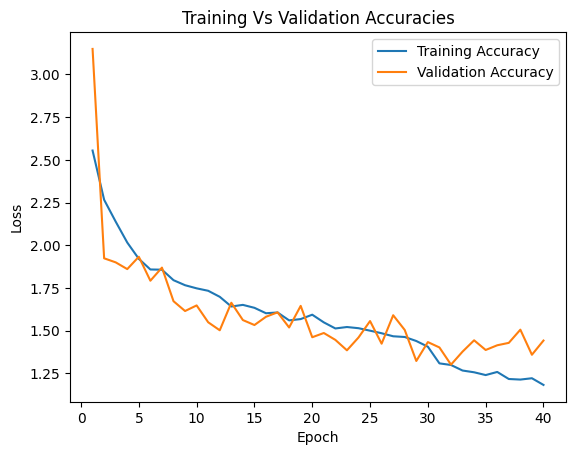

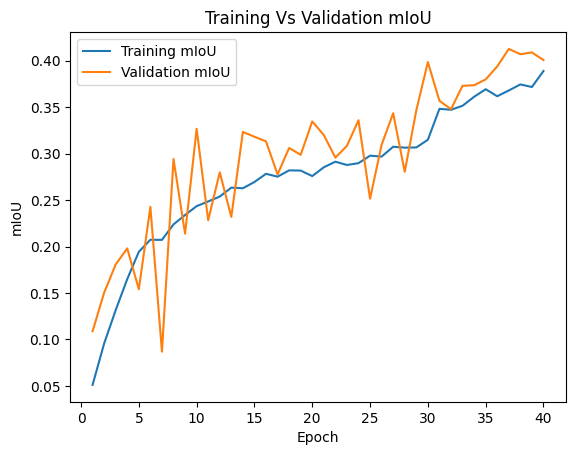

In [19]:
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(range(1, len(history['train_losses'])+1)), history['train_losses'], label="Training Accuracy")
plt.plot(list(range(1, len(history['val_losses'])+1)), history['val_losses'], label="Validation Accuracy")
plt.legend()
plt.show()

plt.title("Training Vs Validation mIoU")
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.plot(list(range(1, len(history['train_iou'])+1)), history['train_iou'], label="Training mIoU")
plt.plot(list(range(1, len(history['val_iou'])+1)), history['val_iou'], label="Validation mIoU")
plt.legend()
plt.show()

In [22]:
test_dataset = SuimTestDataset(test_img_path, test_mask_path)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
iou_scores = []
for idx,(images, masks) in enumerate(test_loader):
    images = images.to(device)
    masks = masks.to(device)

    model.eval()

    with torch.no_grad():
        pred = model(images)
    iou_score = IoU(pred, masks)
    pred = argmax_predict(pred.cpu())

    iou_scores.append(iou_score)

print(f"Test IoU = {np.mean(iou_scores)}")

Test IoU = 0.4405698869013538


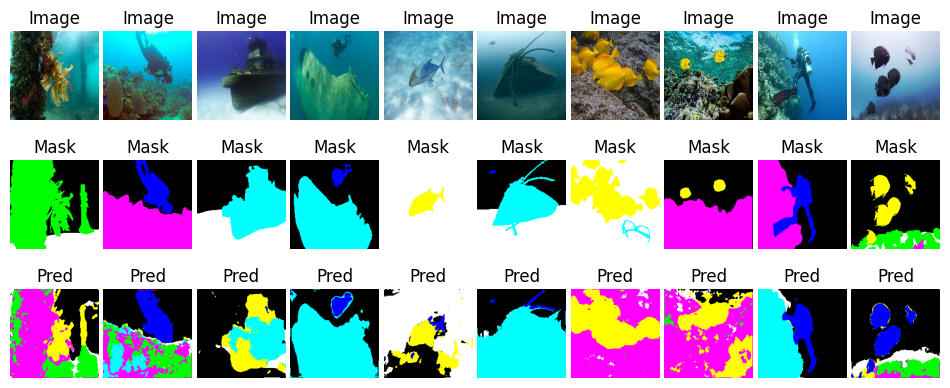

In [23]:
model.eval()
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
images, masks = next(iter(test_loader))
with torch.no_grad():
    preds = model(images.to(device))
preds = argmax_predict(preds.cpu())
preds = torch.from_numpy(preds)

plt.figure(figsize=(12,5))
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title('Image')
    plt.axis('off')
    mask = ohe2bin(masks[i], one_hot_encoded, binary_encoded)
    mask = mask.permute(1, 2, 0)
    plt.subplot(3,10,i+11)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    pred = ohe2bin(preds[i], one_hot_encoded, binary_encoded)
    plt.subplot(3,10,i+21)
    plt.imshow(pred.permute(1, 2, 0))
    plt.title('Pred')
    plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.01)
plt.show()